In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Fuente evaluación llamadas de cobranza

In [4]:
#df_wolkvox = pd.read_excel("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Wolkbox_Bootcamp.xlsx")
df_wolkvox = pd.read_excel("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Dataset/Wolkbox_Bootcamp_Adicionales.xlsx")

In [5]:
# Asegura tipo texto y elimina comillas iniciales ( ' o ’ )

df_wolkvox['CONN_ID'] = (
    df_wolkvox['CONN_ID']
      .astype('string')
      .str.strip()
      .str.replace(r"^[\'’]+", "", regex=True)
)

# Normaliza y filtra (elimina NotA y cualquier cosa distinta a yes/no)

df_wolkvox['YES/NO'] = (
    df_wolkvox['YES/NO']
      .astype(str).str.strip().str.lower()
)
df_wolkvox = df_wolkvox[df_wolkvox['YES/NO'].isin(['yes', 'no'])].copy()

# Mapea a binario yes:0, no:1

df_wolkvox['YES/NO'] = df_wolkvox['YES/NO'].map({'yes': 0, 'no': 1}).astype('Int64')

In [6]:
# Pivotear

df_wolkvox = df_wolkvox.drop(columns=["TYPE_ERROR","CATEGORY"], errors="ignore")

pivot_wolkvox = df_wolkvox.pivot_table(
    index=["CONN_ID", "AGENT_ID", "AREA", "AGENT_NAME", "DATE", "SURVEY", "QUALITY_ANALYST", "CHANNEL", "COMMENT_QAIBOT"],
    columns="ATTRIBUTE",
    values="YES/NO",
    aggfunc="first"   # por si hay duplicados, se queda con el primero
).reset_index()

pivot_wolkvox.columns.name = None

In [7]:
cols_num = [c for c in pivot_wolkvox.columns if re.match(r'^\d', str(c))]
cols_nan_all_num = [c for c in cols_num if pivot_wolkvox[c].isna().all()]
pivot_wolkvox = pivot_wolkvox.drop(columns=cols_nan_all_num)

print(f"Cols numéricas eliminadas ({len(cols_nan_all_num)}):", cols_nan_all_num[:10], "...")

Cols numéricas eliminadas (0): [] ...


In [8]:
# 1) Columnas que empiezan por número (ajusta si quieres otro criterio)
cols_num = [c for c in pivot_wolkvox.columns if re.match(r'^\d', str(c))]

# 2) Subconjunto y coerción a numérico (0/1 -> números; lo demás -> NaN)
sub = pivot_wolkvox[cols_num].apply(pd.to_numeric, errors='coerce')

# 3) Totales por columna y porcentajes
n = len(sub)
tabla_pct = pd.DataFrame({
    '%_1': (sub == 1).sum() / n * 100,
    '%_0': (sub == 0).sum() / n * 100,
    '%_NaN': sub.isna().sum() / n * 100
}).round(2).reset_index().rename(columns={'index': 'variable'})

# 4) (Opcional) ordena por la mayor presencia de 1
tabla_pct = tabla_pct.sort_values('%_1', ascending=False, ignore_index=True)
tabla_pct

,variable,%_1,%_0,%_NaN
0,3.1 Registra y procesa la informacion en el si...,44.04,0.0,55.96
1,2.2 Alternativas de acuerdo a la necesidad,29.12,0.0,70.88
2,4.1 Condiciones de incumplimiento,22.38,0.0,77.62
3,2.3.1 Manejo de Objeciones de acuerdo al perfi...,15.76,0.0,84.24
4,4.2 Explica medios de pago,10.59,0.0,89.41
5,2.3 Manejo de Objeciones de acuerdo al perfil ...,8.54,0.0,91.46
6,1.2 Guion llamada grabada y monitoreada,6.02,0.0,93.98
7,1.3 Tono y Servicio en la Llamada,5.66,0.0,94.34
8,1.1 Apertura de Llamada,5.05,0.0,94.95
9,2.1.1 Escucha Activa No Critico,2.65,0.0,97.35


In [9]:
# (opcional) normaliza vacíos para que cuenten como NaN
pivot_wolkvox = pivot_wolkvox.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})

umbral = 0.95  # 95% NaN o más
na_ratio = pivot_wolkvox.isna().mean()          # proporción de NaN por columna
cols_drop = na_ratio[na_ratio >= umbral].index

print(f"Eliminaré {len(cols_drop)} columnas (≥ {umbral:.0%} NaN)")
pivot_wolkvox = pivot_wolkvox.drop(columns=cols_drop)

Eliminaré 11 columnas (≥ 95% NaN)


In [10]:
# 1) Columnas que empiezan por número (p. ej. "1.1 ...", "2.3 ...")
cols_num = [c for c in pivot_wolkvox.columns if re.match(r'^\d', str(c))]

# 2) Normaliza vacíos para que cuenten como NaN (opcional pero útil)
sub = pivot_wolkvox[cols_num].replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})

# 3) Mascara: filas donde TODAS esas columnas son NaN
mask_all_nan = sub.isna().all(axis=1)

# 4) Eliminar esas filas
n_before = len(pivot_wolkvox)
pivot_wolkvox = pivot_wolkvox.loc[~mask_all_nan].copy()
print(f"Filas eliminadas: {n_before - len(pivot_wolkvox)}")

Filas eliminadas: 31


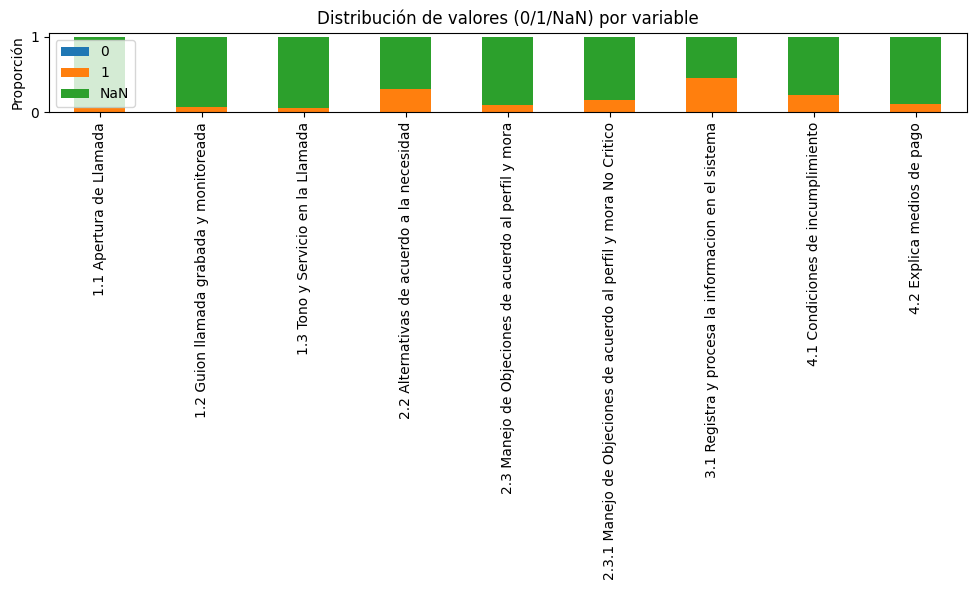

In [11]:
# Graficar

# Columnas que empiezan por número
cols_num = [c for c in pivot_wolkvox.columns if re.match(r'^\d', str(c))]
if not cols_num:
    raise ValueError("No se encontraron columnas que empiecen por número en pivot_wolkvox.")

# Subconjunto y coerción a numérico (por si hay strings)
sub = pivot_wolkvox[cols_num].replace({'yes': 1, 'no': 0}).apply(pd.to_numeric, errors='coerce')

# Conteos por valor
counts = pd.DataFrame({
    '0': (sub == 0).sum(),
    '1': (sub == 1).sum(),
    'NaN': sub.isna().sum()
}).sort_index()

# 4) Gráfico de proporciones (un solo plot, sin especificar colores)
prop = counts.div(counts.sum(axis=1), axis=0).fillna(0.0)

fig, ax = plt.subplots(figsize=(max(10, len(cols_num) * 0.45), 6))
prop[['0', '1', 'NaN']].plot(kind='bar', stacked=True, ax=ax)  # no se fijan colores
ax.set_title("Distribución de valores (0/1/NaN) por variable")
ax.set_ylabel("Proporción")
ax.set_xlabel("")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Transcripciones audios wolkvox

In [12]:
#df = pd.read_csv("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Transcripciones Llamadas Cobranza/transcripciones_gsm_completo.csv")
df = pd.read_csv("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Transcripciones Llamadas Cobranza/transcripciones_gsm_adicionales.csv")

In [13]:
#pd.set_option("display.max_colwidth", None)
pd.reset_option("display.max_colwidth")
df.head(5)

,archivo,duracion_seg,transcripcion
0,agent.12302.date.2024-03-15-14-07-38.tel.12730...,224.0,"¿Aló? ¿Aló? Buenas tardes, no siempre tengo el..."
1,agent.12327.date.2024-05-15-16-18-18.cod.2002....,243.7,aló buenas tardes con quien habló si se haría ...
2,agent.12328.date.2024-08-05-10-57-33.tel.12781...,392.4,"Muy buenos días. Hola, buenos días. Buenos día..."
3,agent.12328.date.2024-08-06-11-34-13.tel.12730...,524.2,"Buenos días. Hola, buenos días. Hablas con Cam..."
4,agent.12328.date.2024-09-10-10-14-10.tel.12730...,250.7,"Hola, mamá. ¿Cómo le puedo ayudar el día de ho..."


In [14]:
pat = r"(?i)id\.((?:\d+\.)*\d+)(?=(?:\.[A-Za-z_]|$))"

df["CONN_ID"] = (
    df["archivo"].astype(str)
      .str.extract(pat, expand=False)
      .astype("string")
)

# Unión

In [15]:
merged = df.merge(pivot_wolkvox[['CONN_ID','AGENT_ID','SURVEY','1.1 Apertura de Llamada',
                 '2.2 Alternativas de acuerdo a la necesidad','4.1 Condiciones de incumplimiento',
                 '4.2 Explica medios de pago']], on='CONN_ID', how='left')
merged

,archivo,duracion_seg,transcripcion,CONN_ID,AGENT_ID,SURVEY,1.1 Apertura de Llamada,2.2 Alternativas de acuerdo a la necesidad,4.1 Condiciones de incumplimiento,4.2 Explica medios de pago
0,agent.12302.date.2024-03-15-14-07-38.tel.12730...,224.0,"¿Aló? ¿Aló? Buenas tardes, no siempre tengo el...",1710529239.97149.035713,12730.0,CARTERA,<NA>,1,1,<NA>
1,agent.12327.date.2024-05-15-16-18-18.cod.2002....,243.7,aló buenas tardes con quien habló si se haría ...,12327.9612.1715807654.69771,12327.0,CARTERA,<NA>,1,<NA>,<NA>
2,agent.12328.date.2024-08-05-10-57-33.tel.12781...,392.4,"Muy buenos días. Hola, buenos días. Buenos día...",1722872776.19700.510459,12781.0,CARTERA,<NA>,<NA>,1,<NA>
3,agent.12328.date.2024-08-06-11-34-13.tel.12730...,524.2,"Buenos días. Hola, buenos días. Hablas con Cam...",1722961214.28086.253394,12730.0,CARTERA,<NA>,<NA>,<NA>,1
4,agent.12328.date.2024-09-10-10-14-10.tel.12730...,250.7,"Hola, mamá. ¿Cómo le puedo ayudar el día de ho...",1725980774.26222.100219,12730.0,CARTERA,1,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...
369,customer.66917755.agent.12939.date.2024-04-17-...,298.2,"Buenos días, creador de la Labitor, ¿cómo hace...",2009.9769.7220.1713361363.10017,12939.0,CARTERA,<NA>,<NA>,1,1
370,customer.66951573.agent.12941.date.2024-10-16-...,563.0,"Buenas tardes, habla con Mónica Rayos. Muy bue...",1729112210.83541.001787,12941.0,CARTERA,<NA>,<NA>,1,<NA>
371,customer.73185883.agent.12610.date.2024-01-03-...,376.1,"Le he dicho a Sorbel, habla Isabel Rodríguez e...",1742.9769.6298.1704314881.63780,12610.0,CARTERA,<NA>,1,<NA>,<NA>
372,customer.79881088.agent.12766.date.2024-07-12-...,334.3,¿Qué más créditos me queda a la Juliana? ¿Ves ...,8275.9769.9135.1720810987.38736,12766.0,CARTERA,<NA>,<NA>,1,1


In [16]:
merged.columns

Index(['archivo', 'duracion_seg', 'transcripcion', 'CONN_ID', 'AGENT_ID',
       'SURVEY', '1.1 Apertura de Llamada',
       '2.2 Alternativas de acuerdo a la necesidad',
       '4.1 Condiciones de incumplimiento', '4.2 Explica medios de pago'],
      dtype='object')

In [17]:
cols = merged.columns[merged.columns.get_loc('SURVEY') + 1:]

# Subconjunto forzado a numérico (1/0; lo demás -> NaN)
sub = merged[cols].apply(pd.to_numeric, errors='coerce')

N = len(sub)  # base = total de filas

tabla = pd.DataFrame({
    'n_1':   (sub == 1).sum(),
    '%_1':   (sub == 1).sum() / N * 100,
    'n_0':   (sub == 0).sum(),
    '%_0':   (sub == 0).sum() / N * 100,
    'n_vacio': sub.isna().sum(),
    '%_vacio': sub.isna().sum() / N * 100
}).round(2).reset_index().rename(columns={'index': 'variable'})

# (opcional) ordenar por mayor % de 1
tabla = tabla.sort_values('%_1', ascending=False, ignore_index=True)

tabla


,variable,n_1,%_1,n_0,%_0,n_vacio,%_vacio
0,2.2 Alternativas de acuerdo a la necesidad,214,57.22,0,0.0,160,42.78
1,4.1 Condiciones de incumplimiento,163,43.58,0,0.0,211,56.42
2,4.2 Explica medios de pago,81,21.66,0,0.0,293,78.34
3,1.1 Apertura de Llamada,20,5.35,0,0.0,354,94.65


In [18]:
merged['duracion_seg'].max()

1384.1

In [19]:
merged.to_excel('/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Dataset/Transcripciones_Variables_Adicionales.xlsx', index=False)